<Figure size 1000x600 with 0 Axes>

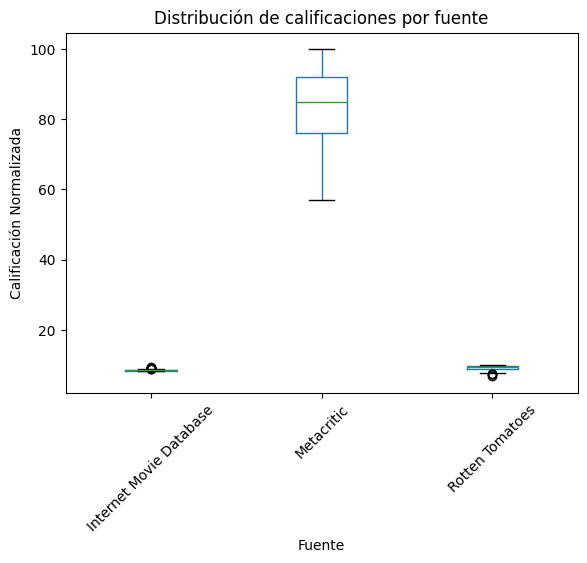

Proceso completado.


In [3]:
import sqlite3
import requests
from textblob import TextBlob
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Cargar variables de entorno
load_dotenv()
IMDB_API_KEY = os.getenv("IMDB_API_KEY")
OMDB_API_KEY = os.getenv("OMDB_API_KEY")

if not IMDB_API_KEY or not OMDB_API_KEY:
    raise ValueError("API keys are not set in the environment variables.")

# Reiniciar base de datos si existe
if os.path.exists("movies.db"):
    os.remove("movies.db")

# Conectar a la base de datos
def connect_db():
    return sqlite3.connect("movies.db")

# Crear tablas
def create_tables():
    conn = connect_db()
    try:
        cursor = conn.cursor()
        cursor.executescript('''
            CREATE TABLE MOVIES (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                imdb_id TEXT UNIQUE,
                rank INTEGER,
                title TEXT,
                description TEXT,
                image TEXT,
                year INTEGER,
                imdb_rating REAL,
                imdb_url TEXT
            );
            
            CREATE TABLE MOVIE_GENRES (
                movie_id INTEGER,
                genre TEXT,
                FOREIGN KEY(movie_id) REFERENCES MOVIES(id)
            );
            
            CREATE TABLE RATINGS (
                movie_id INTEGER,
                source TEXT,
                normalized_rating REAL,
                FOREIGN KEY(movie_id) REFERENCES MOVIES(id)
            );
            
            CREATE TABLE REVIEWS (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                movie_id INTEGER,
                user_review TEXT,
                sentiment REAL,
                FOREIGN KEY(movie_id) REFERENCES MOVIES(id)
            );
        ''')
        conn.commit()
    finally:
        conn.close()

# Obtener películas desde IMDb API
def fetch_imdb_movies():
    url = "https://imdb-top-100-movies.p.rapidapi.com/"
    headers = {
        "x-rapidapi-key": IMDB_API_KEY,
        "x-rapidapi-host": "imdb-top-100-movies.p.rapidapi.com"
    }
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"Error fetching IMDb movies: {e}")
        return []

# Obtener ratings desde OMDb API
def fetch_movie_ratings(imdb_id):
    url = f"http://www.omdbapi.com/?i={imdb_id}&apikey={OMDB_API_KEY}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        return data.get("Ratings", []), data.get("imdbRating", "0.0")
    except requests.RequestException as e:
        print(f"Error fetching ratings for {imdb_id}: {e}")
        return [], "0.0"

# Insertar película y obtener su ID
def insert_movie(movie, imdb_rating):
    conn = connect_db()
    try:
        cursor = conn.cursor()
        cursor.execute("""
            INSERT OR IGNORE INTO MOVIES (imdb_id, rank, title, description, image, year, imdb_rating, imdb_url)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        """, (
            movie.get("imdbid"),
            movie.get("rank"),
            movie.get("title", "Unknown Title"),
            movie.get("description", "No description available"),
            movie.get("image"),
            movie.get("year"),
            float(imdb_rating),
            movie.get("imDbUrl", "")
        ))
        conn.commit()
        cursor.execute("SELECT id FROM MOVIES WHERE imdb_id = ?", (movie.get("imdbid"),))
        movie_id = cursor.fetchone()[0]
        
        genres = movie.get("genre", [])
        if isinstance(genres, list):
            for genre in genres:
                cursor.execute("INSERT INTO MOVIE_GENRES (movie_id, genre) VALUES (?, ?)", (movie_id, genre))
        conn.commit()
        return movie_id
    finally:
        conn.close()

# Insertar ratings
def insert_ratings(movie_id, ratings):
    if not ratings:
        return
    conn = connect_db()
    try:
        cursor = conn.cursor()
        for rating in ratings:
            source = rating.get("Source", "Unknown Source")
            value = rating.get("Value", "0/10")
            
            normalized = float(value.split("/")[0]) if "/" in value else float(value.replace("%", "")) / 10
            
            cursor.execute("INSERT INTO RATINGS (movie_id, source, normalized_rating) VALUES (?, ?, ?)", (movie_id, source, normalized))
        conn.commit()
    finally:
        conn.close()

# Análisis estadístico
def analyze_ratings():
    conn = connect_db()
    df = pd.read_sql_query("SELECT source, normalized_rating FROM RATINGS", conn)
    conn.close()
    
    plt.figure(figsize=(10, 6))
    df.boxplot(by="source", column=["normalized_rating"], grid=False)
    plt.title("Distribución de calificaciones por fuente")
    plt.suptitle("")
    plt.xlabel("Fuente")
    plt.ylabel("Calificación Normalizada")
    plt.xticks(rotation=45)
    plt.show()

# Ejecutar script
if __name__ == "__main__":
    create_tables()
    movies = fetch_imdb_movies()
    for movie in movies:
        ratings, imdb_rating = fetch_movie_ratings(movie.get("imdbid"))
        movie_id = insert_movie(movie, imdb_rating)
        insert_ratings(movie_id, ratings)
        insert_reviews(movie_id)
    analyze_ratings()
    print("Proceso completado.")